In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import glob
import ast
import matplotlib.cm as cm
from scipy import ndimage
import cooler
import chromoscores.maputils as chrmap
import chromoscores.snipping as chrsnip
import chromoscores.scorefunctions as chrscores
import seaborn as sns

To extract the average properties of a feature in a Hi-C map, we can make a summation of the snippets with specified feature (e.g., TADs). In this notebook we showed the usage of pile-up functions for the analysis of few fetures. For the average properties such as flames we might be interested in working on normalized map, to be unbiased with respect to the distance from the diagonal.

### Loading simulated data

In [2]:
path_dict = {}

directory = '/home1/rahmanin/start/polychrom/projects/Dynamic_boundary_elements/analysis/maps/maps_points_cools_eq/'

for name  in glob.glob(directory+'folder_*'):
    path_dict[name.split('_eq/')[1][:].split('.mcool')[0]]= name
path_dict = dict(sorted(path_dict.items()))
print(len(path_dict))

499


### Analysis

### investigating iso score

folder_face_1.0_back_0_Clife_11428.57_Cof_571.43_life_3500.0_slife_3500.0_birth_0.1_pause_0.9_sep_100_site_10_monomer_1000_replica_10_steps_175.0_vel_1
750


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log10


1.248664182088285
(29, 29) 30


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log10


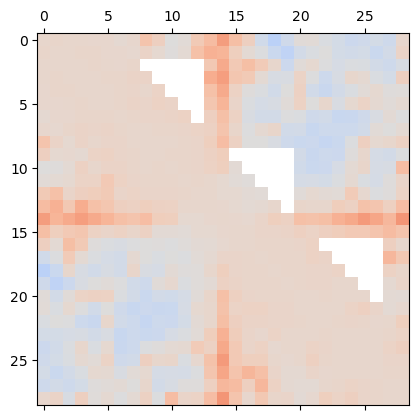

In [5]:
delta_val = 2
diag_offset_val = 5
max_distance_val = 20


#List of the position of boundary elements on the main diagonal. 

ctcfrightlist = [314, 579, 1195, 3717, 3772, 3921, 4451, 5193, 5723, 6302, 6574, 6779, 7000, 9232, 9310, 9861]
ctcfleftlist = [495, 865, 1404, 2164, 3143, 3615, 3971, 4069, 4480, 4938, 5300, 5587, 6401, 7725, 8764, 9619]
lst = np.sort((ctcfrightlist + ctcfleftlist))
lst = [int(lst[i]/(10*4) ) for i in range(len(lst))] # the 4 multiplier is for adjusting ctcf positions in 10 kb resolution
lst = np.array(lst)

### list of boundary elements on all replications
rep = 3 
mon = 1000//4
site = 10
lst_t = []
for i in range(rep):
    lst_t += list(np.array(lst)+i*mon)
lst_t = np.array(lst_t)
#print(lst_t)

for name in list(path_dict.keys())[150:151]:
    print(name)
    params=[ast.literal_eval(i) for i in name.split('folder_')[1].split('_')[1::2]]
    face, back,clife, cof, life, slife, birth, pause, sep, site, mon, rep, step, vel = params
    if step==400.0: continue
    cool_uri = (directory + '%s.mcool'%name)
    region = 'chr_sim:0-7500000' #region = 'chr_sim:0-7500000'
    cname = (cooler.Cooler(cool_uri+'.10000.cool').matrix(balance=False).fetch(region))
    mat=cname
    print(len(mat))
    mrcn = mat
    mrc  = mrcn.astype(float)
    mat = np.log10(mrc)
    mrc_exp=chrmap.get_observed_over_expected(mrc)
    pile=chrmap.get_diagonal_pileup(mrc_exp, lst_t[5:91],60)   #A function to pile up snippets around investigated features (here boundary elements)
    a,b,pile_c=chrscores._get_isolation_areas(pile,delta=delta_val,
                                              diag_offset=diag_offset_val,
                                              max_distance=max_distance_val,
                                              snippet_shapes='triangle')
    clr = cooler.Cooler(cool_uri+'.10000.cool')
    pseudocount = 0
    score=chrscores.isolation_score(pile,
                                    delta=delta_val,
                                    diag_offset=diag_offset_val,
                                    max_dist=max_distance_val,
                                    snippet_shapes='triangle',
                                    pseudo_count=pseudocount)
    print(score)
    print(np.shape(pile_c),len(a[a!=0]))
    for i in range(1):
        plt.matshow(np.log10(pile_c-(a+b)),vmin=0.9995,vmax=2.71,cmap='coolwarm')
    plt.show()

### Analysis

In [6]:
file=pd.read_csv('../../../data/isoscore_for_dynamic_random_pause_mod_1_5_30_traiangles_coolres10_s.csv')
file 

,life,velocity,clife,cof,isoscore
0,1500.0,1,1.5,0.15,1.011432
1,500.0,1,1.5,0.15,1.033661
2,1500.0,1,1.5,0.30,1.007476
3,500.0,1,1.5,0.30,1.001202
4,1500.0,1,1.5,1.00,1.004684
...,...,...,...,...,...
157,500.0,1,5000.0,3.00,1.351247
158,1500.0,1,5000.0,50.00,1.342616
159,500.0,1,5000.0,50.00,1.335082
160,1500.0,1,5000.0,500.00,1.296984


In [7]:
lifetime = file['life']
velocity = file['velocity']
clife = file['clife']
cof = file['cof']

unique_life = np.unique(lifetime)
unique_vel = np.unique(velocity)
unique_clife = np.unique(clife)
unique_cof = np.unique(cof)

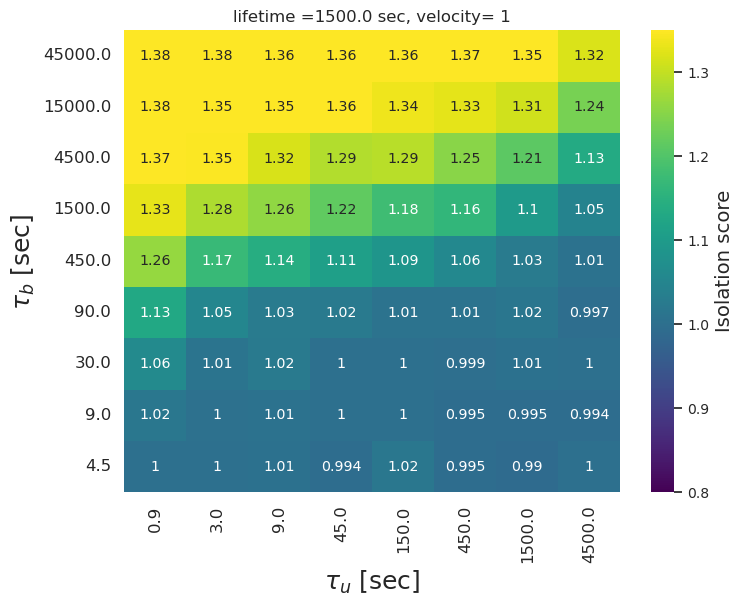

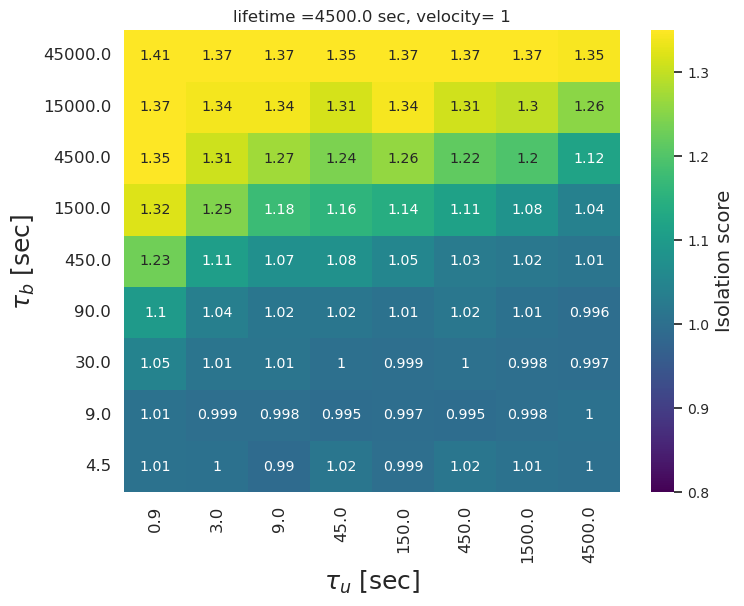

In [12]:
vel = 1
convertor = 25 * 60 / 500
for life in list(unique_life):
    for vel in list(unique_vel):
        new_file = file[(lifetime == life)&(velocity == vel) ][['clife','cof','isoscore']]
        new_file = new_file[new_file['cof']>0.15]
        new_file['clife']= convertor* new_file['clife']
        new_file['cof']= convertor*new_file['cof']
        heatmap_data = new_file.pivot('clife', 'cof', 'isoscore')
        # Create the heatmap using seaborn
        plt.figure(figsize=(8, 6))
        im = sns.heatmap(heatmap_data, annot=True, cmap='viridis', vmax=1.35, vmin =0.8, fmt='.3g',cbar_kws={'label': 'Isolation score'} )
        sns.set(font_scale=0.851)
        cbar = im.collections[0].colorbar
        cbar.ax.tick_params(labelsize=10)
        cbar.set_label('Isolation score', fontsize=14.15)
        # Customize labels and title
        im.set_xticklabels(['{:.1f}'.format(float(t.get_text())) for t in im.get_xticklabels()])
        plt.xlabel(r'$\tau_u$ [sec]', fontsize = 18)
        plt.ylabel(r'$\tau_b$ [sec]', fontsize =18)
        plt.title('lifetime =%s sec, velocity= %s'%(life*convertor, vel), fontsize = 11.95)
        plt.gca().invert_yaxis()
        plt.xticks(fontsize=11.95)
        plt.yticks(fontsize=11.95)
        plt.savefig('../../../images/isolation_for_%s_%s_coolres10.pdf'%(life, vel), transparent = True, bbox_inches = 'tight')
        plt.show()

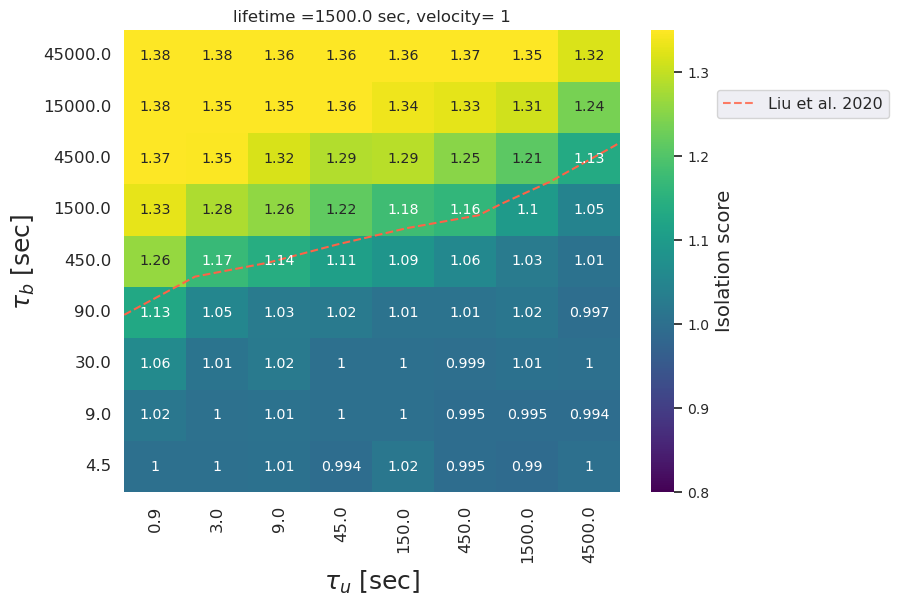

In [15]:
unique_life, unique_vel = [500.0], [1]
convertor = 25 * 60 / 500
file=pd.read_csv('../../../data/isoscore_for_dynamic_random_pause_mod_1_5_30_traiangles_coolres10_s.csv')
#print(file)

for life in list(unique_life):
    for vel in list(unique_vel):
        new_file = file[(lifetime == life)&(velocity == vel) ][['clife','cof','isoscore']]
        new_file = new_file[new_file['cof']>0.15]
        new_file['clife']= convertor* new_file['clife']
        new_file['cof']= convertor*new_file['cof']
        heatmap_data = new_file.pivot('clife', 'cof', 'isoscore')


        smooth_scale = 1
        z = ndimage.zoom(heatmap_data.to_numpy(), smooth_scale)
        
        # Create the heatmap using seaborn
        plt.figure(figsize=(8, 6))
        im = sns.heatmap(heatmap_data, annot=True, cmap='viridis', vmax=1.35, vmin =0.8, fmt='.3g',cbar_kws={'label': 'Isolation score'} )
        sns.set(font_scale=0.851)
        cbar = im.collections[0].colorbar
        cbar.ax.tick_params(labelsize=10)
        cbar.set_label('Isolation score', fontsize=14.15)


        
        # Add equipotential lines for loop size = 700
        cntr1 = im.contour(np.linspace(0, 8, 8*smooth_scale),
                           np.linspace(0, 9, 9*smooth_scale),
                           heatmap_data.to_numpy(), levels=[1.14], colors='tomato', linestyles='dashed', alpha=1) 
        # Add legend manually for the contours
        #hansen_line, = plt.plot([], [], color='cyan', linestyle='dashed', alpha=0.83, label='Hansen et al., 2017')
        Liu_line, = plt.plot([], [], color='tomato', linestyle='dashed', alpha=0.83, label='Liu et al. 2020')
        #cntr3 = im.contour(np.linspace(0, 8, 8*smooth_scale),
        #                   np.linspace(0, 9, 9*smooth_scale),
        #                   heatmap_data.to_numpy(), levels=[1.215], colors='cyan', linestyles='dashed', alpha=0.93) 

        
        x_cntr1 = np.linspace(0, 8, 8*smooth_scale)
        y_cntr1 = np.interp(x_cntr1, cntr1.collections[0].get_paths()[0].vertices[:,0], 
                            cntr1.collections[0].get_paths()[0].vertices[:,1])
        


        # Customize labels and title
        im.set_xticklabels(['{:.1f}'.format(float(t.get_text())) for t in im.get_xticklabels()])
        plt.xlabel(r'$\tau_u$ [sec]', fontsize = 18)
        plt.ylabel(r'$\tau_b$ [sec]', fontsize =18)
        plt.title('lifetime =%s sec, velocity= %s'%((life*3), vel), fontsize = 11.95)
        plt.gca().invert_yaxis()
        plt.xticks(fontsize=11.95)
        plt.yticks(fontsize=11.95)
        # Add legend
        plt.legend(handles=[Liu_line], loc=(1.195,0.81), fontsize =11.5)
        plt.savefig('../../../images/isolation_for_%s_%s_coolres10_estimate_exp.pdf'%(life, vel), transparent = True, bbox_inches = 'tight')
        # Show the plot
        plt.show()






### binding time 

In [51]:
path = '/home1/rahmanin/start/polychrom/projects/Dynamic_boundary_elements/analysis/notebooks/repository/rep/processing/Outputs'

file=pd.read_csv(path + '/isolation_score_traiangles_coolres10.csv')
file
file ['occupancy']=(file['clife']/(file['clife']+file['cof'])).round(2)

In [52]:
file

,life,velocity,clife,cof,isoscore,occupancy
0,1500.0,1,11.43,1.27,1.015728,0.90
1,2500.0,1,11.43,1.27,1.006505,0.90
2,3500.0,1,11.43,1.27,1.009840,0.90
3,4500.0,1,11.43,1.27,1.023998,0.90
4,500.0,1,11.43,1.27,1.028575,0.90
...,...,...,...,...,...,...
494,2500.0,1,571.43,97.96,1.113156,0.85
495,3500.0,1,571.43,97.96,1.102595,0.85
496,4500.0,1,571.43,97.96,1.076937,0.85
497,500.0,1,571.43,97.96,1.180362,0.85


In [53]:
convertor = 21.875*60/500
file['clife']=file['clife']
file['cof']=file['cof']
lifetime = file['life']
velocity = file['velocity']
clife = file['clife']
cof = file['cof']
occupancy = file['occupancy']

#file_100 = file

unique_life = np.unique(lifetime)
unique_vel = np.unique(velocity)
unique_clife = np.unique(clife)
unique_cof = np.unique(cof)
unique_occup = np.unique(occupancy)

In [54]:
new_file_filtered_unique = file[(lifetime == life)&(velocity == vel) ][['clife','occupancy','isoscore']]

#new_file_filtered_unique['occupancy_bin'] = pd.cut(new_file_filtered_unique['occupancy'], bins=bins, labels=labels, right=False)

dtaframe = new_file_filtered_unique[['clife', 'occupancy', 'isoscore']]
#dtafram = dtaframe.dropna()
dtaframe = new_file_filtered_unique[['clife', 'occupancy', 'isoscore']]
#dtaframe_grouped = dtaframe.groupby(['clife', 'occupancy'], as_index=False).mean()
#dtaframe_grouped = dtaframe.dropna()
dtaframe_grouped = dtaframe
dtaframe_grouped

,clife,occupancy,isoscore
4,11.43,0.90,1.028575
10,11.43,0.50,1.003209
16,11.43,0.80,1.017633
27,11.43,0.60,1.020504
33,11.43,0.10,0.999536
...,...,...,...
473,571.43,0.10,1.024528
479,571.43,0.50,1.094925
485,571.43,0.90,1.206455
491,571.43,0.40,1.081060


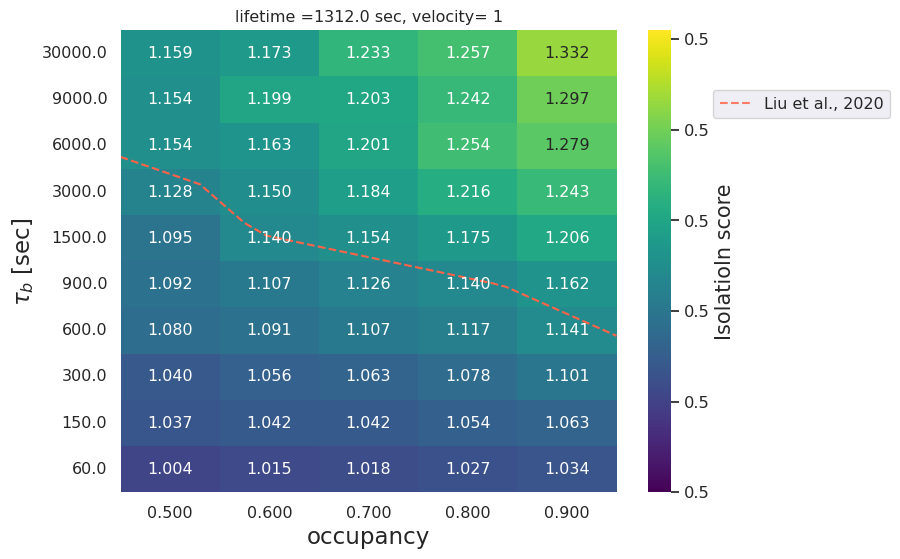

In [55]:
list_life, list_vel = [500], [1]

numline_c = 10
numline_o =5
occupancy_range = [0.5, 0.6, 0.7, 0.8, 0.9]
file = file[file['occupancy'].isin(occupancy_range)]
lifetime = file['life']
velocity = file['velocity']
for life in list(list_life):
    for vel in list(list_vel):
        new_file_filtered_unique = file[(lifetime == life)&(velocity == vel) ][['clife','occupancy','isoscore']]


        
        # Group by 'clife' and 'occupancy_bin', and calculate the mean of 'isoscore'
        dtaframe_grouped = new_file_filtered_unique.groupby(['clife', 'occupancy'], as_index=False).mean()
        convertor = 21.875*60/500
        dtaframe_grouped ['clife']= (dtaframe_grouped['clife']*convertor).round()
        dtaframe = dtaframe.drop_duplicates(keep='first')
        #print(dtaframe)
        dtaframe_grouped = dtaframe_grouped[dtaframe_grouped['clife']>30]
        heatmap_data = dtaframe_grouped.pivot('clife', 'occupancy', 'isoscore')
                
        plt.figure(figsize=(8, 6))
        im = sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".3f",vmin=0.90,vmax=1.41, cbar_kws={'label': 'Frip score','format':'0.5'} )
        sns.set(font_scale=0.831)
        cbar = im.collections[0].colorbar
        cbar.ax.tick_params(labelsize=11.75)
        cbar.set_label('Isolatioln score', fontsize=15)
        
        # Add equipotential lines for loop size = 700
        smooth_scale = 1
        z = ndimage.zoom(heatmap_data.to_numpy(), smooth_scale)
        cntr1 = im.contour(np.linspace(0, numline_o, numline_o * smooth_scale),
                           np.linspace(0, numline_c, numline_c * smooth_scale),
                           heatmap_data.to_numpy(), levels=[1.1421], colors='tomato',  linestyles='dashed', alpha=1)
        
        hansen_line, = plt.plot([], [], color='tomato', linestyle='dashed', alpha=0.83, label='Liu et al., 2020')

        
        
        im.set_xticklabels(['{:.3f}'.format(float(t.get_text())) for t in im.get_xticklabels()])
        ytick_labels = [int(float(t.get_text())) for t in im.get_yticklabels()]
        plt.xlabel(r'occupancy', fontsize = 16.5)
        plt.xticks(fontsize =11.5, rotation=0)
        plt.ylabel(r'$\tau_b$ [sec]', fontsize =16.5)
        plt.yticks(fontsize = 11.5, rotation = 0)
        plt.title('lifetime =%s sec, velocity= %s'%(np.round(life*convertor), vel), fontsize = 11.5)
        # Add legend
        plt.legend(handles=[hansen_line], loc=(1.195,0.81), fontsize =11.5)
        plt.gca().invert_yaxis()
        #plt.savefig('../../images/isosweep_for_occupancy_%s_%s.pdf'%(life, vel), transparent = True, bbox_inches = 'tight')
        plt.show()

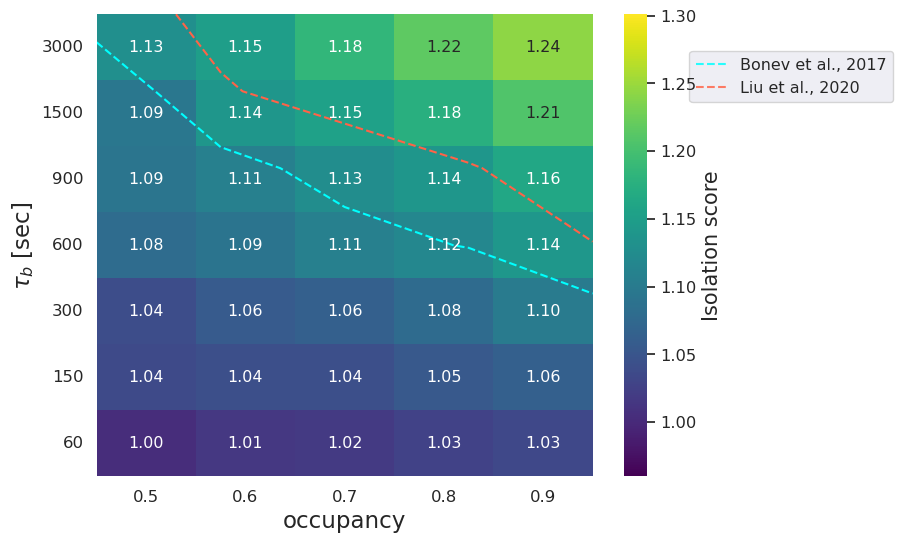

In [60]:
list_life, list_vel = [500], [1]

numline_c = 7
numline_o = 5
occupancy_range = [0.5, 0.6, 0.7, 0.8, 0.9]
file = file[file['occupancy'].isin(occupancy_range)]
lifetime = file['life']
velocity = file['velocity']

for life in list(list_life):
    for vel in list(list_vel):
        new_file_filtered_unique = file[(lifetime == life) & (velocity == vel)][['clife', 'occupancy', 'isoscore']]
        
        # Group by 'clife' and 'occupancy_bin', and calculate the mean of 'isoscore'
        dtaframe_grouped = new_file_filtered_unique.groupby(['clife', 'occupancy'], as_index=False).mean()
        convertor = 21.875 * 60 / 500
        dtaframe_grouped['clife'] = (dtaframe_grouped['clife'] * convertor).round()
        dtaframe_grouped = dtaframe_grouped.drop_duplicates(keep='first')
        dtaframe_grouped = dtaframe_grouped[dtaframe_grouped['clife'] > 30]
        dtaframe_grouped = dtaframe_grouped[dtaframe_grouped['clife'] <= 3000]
        heatmap_data = dtaframe_grouped.pivot('clife', 'occupancy', 'isoscore')
        
        plt.figure(figsize=(8, 6))
        im = sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f", vmin=0.96, vmax=1.301, cbar_kws={'label': 'Frip score'})
        sns.set(font_scale=0.951)
        cbar = im.collections[0].colorbar
        cbar.ax.tick_params(labelsize=11.75)
        cbar.set_label('Isolation score', fontsize=15)
        
        # Add equipotential lines for loop size = 700
        smooth_scale = 1
        z = ndimage.zoom(heatmap_data.to_numpy(), smooth_scale)
        cntr1 = im.contour(np.linspace(0, numline_o, numline_o * smooth_scale),
                           np.linspace(0, numline_c, numline_c * smooth_scale),
                           heatmap_data.to_numpy(), levels=[1.1421], colors='tomato', linestyles='dashed', alpha=1)
        cntr3 = im.contour(np.linspace(0, numline_o, numline_o * smooth_scale),
                           np.linspace(0, numline_c, numline_c * smooth_scale),
                           heatmap_data.to_numpy(), levels=[1.116], colors='cyan', linestyles='dashed', alpha=1)
        
        # Add legend manually for the contours
        hansen_line, = plt.plot([], [], color='cyan', linestyle='dashed', alpha=0.83, label='Bonev et al., 2017')
        
        liu_line, = plt.plot([], [], color='tomato', linestyle='dashed', alpha=0.83, label='Liu et al., 2020')

        # Format tick labels
        im.set_xticklabels([int(float(t.get_text())) if float(t.get_text()).is_integer() else t.get_text() for t in im.get_xticklabels()])
        im.set_yticklabels([int(float(t.get_text())) if float(t.get_text()).is_integer() else t.get_text() for t in im.get_yticklabels()])

        plt.xlabel('occupancy', fontsize=16.5)
        plt.xticks(fontsize=11.95, rotation=0)
        plt.ylabel(r'$\tau_b$ [sec]', fontsize=16.5)
        plt.yticks(fontsize=11.95, rotation=0)
        #plt.title(r'$\tau_E$ = %s sec, velocity = %s' % (np.round(life * convertor), vel), fontsize=11.95)
        # Add legend
        plt.legend(handles=[hansen_line, liu_line], loc=(1.195, 0.81), fontsize=11.5)
        plt.gca().invert_yaxis()
        plt.savefig('isosweep_for_occupancy_%s_%s.pdf'%(life, vel), transparent = True, bbox_inches = 'tight')
        plt.show()


In [25]:
file=pd.read_csv('../../../data/isoscore_for_dynamic_random_pause_mod_1_5_30_traiangles_coolres10_s_points.csv')
file
file ['occupancy']=(file['clife']/(file['clife']+file['cof'])).round(3)
convertor = 21.875*60/500
file['clife']=file['clife']
file['cof']=file['cof']
lifetime = file['life']
velocity = file['velocity']
clife = file['clife']
cof = file['cof']
occupancy = file['occupancy']


unique_life = np.unique(lifetime)
unique_vel = np.unique(velocity)
unique_clife = np.unique(clife)
unique_cof = np.unique(cof)
unique_occup = np.unique(occupancy)
#file = file[file['clife']>=3]


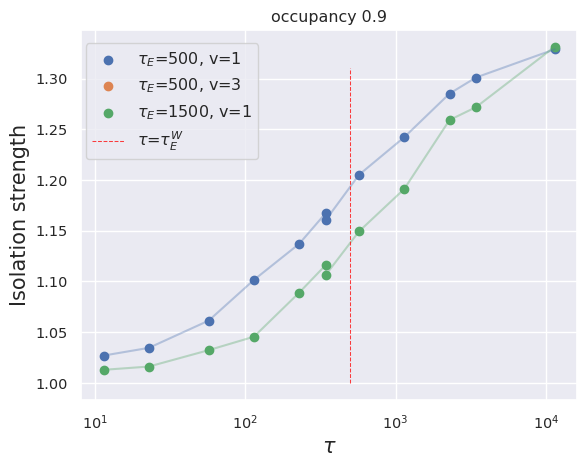

In [26]:
lifes, vels = [500, 1500] , [1, 3]

        

for life in lifes:
    for vel in vels:
        if (life==1500 and vel==3): continue
        new_file = file[(lifetime == life)&(velocity == vel)&(file['occupancy'] == 0.90)][['clife','cof', 'isoscore']]
        new_file_filtered = new_file.drop_duplicates(keep = 'first')
        new_file_filtered = new_file_filtered.sort_values('clife')
        new_clife = new_file_filtered['clife']
        iso_score = new_file_filtered['isoscore']
        plt.scatter(new_clife[:],iso_score[:], label=r'$\tau_E$=%s, v=%s'%(life,vel))
        #print(new_clife)
        plt.plot(new_clife[:],iso_score[:], alpha = 0.35)
life_w = 500
plt.plot([life_w, life_w, life_w],[1, 1.15,1.31],'--', color = 'red',alpha = 0.75, linewidth = 0.75, label = r'$\tau$=$\tau^W_E$')
        #plt.ylim(0,0.5)
#plt.xlim()
plt.title('occupancy 0.9')
plt.xscale('log')
plt.legend(fontsize = 11.5,loc = (0.01,0.65))
plt.ylabel('Isolation strength',fontsize = 15)
plt.xlabel(r'$\tau$', fontsize = 15)
#plt.savefig('frip_for_tau.png')
plt.show()

### iso wt vs iso wapl

In [27]:
path = '/home1/rahmanin/start/polychrom/projects/Dynamic_boundary_elements/analysis/notebooks/repository/rep/processing/Outputs'

iso = pd.read_csv(path + '/isolation_score_traiangles_coolres10.csv')

iso

In [29]:
iso['occup']= (iso['clife']/(iso['clife']+iso['cof'])).round(2)

In [30]:
iso_wt, iso_wapl  = iso[iso['life']==500], iso[iso['life']==1500]
iso_wt


,life,velocity,clife,cof,isoscore,occup
4,500.0,1,11.43,1.27,1.028575,0.90
10,500.0,1,11.43,11.43,1.003209,0.50
16,500.0,1,11.43,2.86,1.017633,0.80
27,500.0,1,11.43,7.62,1.020504,0.60
33,500.0,1,11.43,97.96,0.999536,0.10
...,...,...,...,...,...,...
473,500.0,1,571.43,4897.96,1.024528,0.10
479,500.0,1,571.43,571.43,1.094925,0.50
485,500.0,1,571.43,63.49,1.206455,0.90
491,500.0,1,571.43,857.14,1.081060,0.40


In [96]:
common_columns = [ 'velocity', 'clife', 'cof', 'occup']

# Merge the datasets on the common columns
iso_wt_70 = iso_wt[iso_wt['occup']==0.70]
iso_wapl_70 = iso_wapl[iso_wapl['occup']==0.70]
merged_df = pd.merge(iso_wt_70, iso_wapl_70, on=common_columns, how='inner')
merged_df ['clife'] = (merged_df['clife']*convertor).round()
merged_df

,life_x,velocity,clife,cof,isoscore_x,occup,life_y,isoscore_y
0,500.0,1,300.0,48.98,1.063085,0.7,1500.0,1.046756
1,500.0,1,3000.0,489.80,1.184160,0.7,1500.0,1.153297
2,500.0,1,30000.0,4897.96,1.232775,0.7,1500.0,1.227295
3,500.0,1,60.0,9.80,1.018362,0.7,1500.0,1.010843
4,500.0,1,600.0,97.96,1.106563,0.7,1500.0,1.053191
5,500.0,1,6000.0,979.59,1.200776,0.7,1500.0,1.198396
6,500.0,1,900.0,146.94,1.125558,0.7,1500.0,1.089363
7,500.0,1,9000.0,1469.39,1.203254,0.7,1500.0,1.190629
8,500.0,1,150.0,24.49,1.042171,0.7,1500.0,1.034764
9,500.0,1,1500.0,244.90,1.154081,0.7,1500.0,1.108930


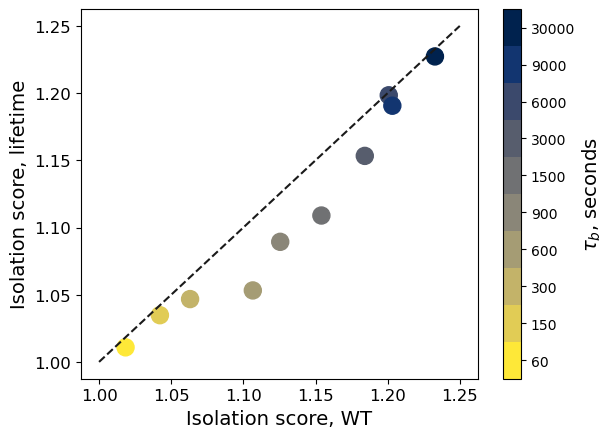

In [98]:
# Reset Seaborn's default parameters
sns.reset_defaults()


# Sort the DataFrame based on 'clife'
merged_df = merged_df.sort_values(by=['clife'])

# Number of unique points (colors) you want
num_colors = len(merged_df['clife'].unique())

# Create a discrete colormap with 'num_colors' colors
cmap = plt.cm.get_cmap('cividis_r', num_colors)

# Normalize the 'clife' values to integers (0, 1, ..., num_colors-1)
norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, num_colors), ncolors=num_colors)

# Map 'clife' values to integers for discrete coloring
clife_indices = merged_df['clife'].rank(method='dense').astype(int) - 1

# Create a scatter plot using discrete colors
sc = plt.scatter(
    merged_df['isoscore_x'], 
    merged_df['isoscore_y'],
    s=150, 
    c=clife_indices,  # Use mapped indices for coloring
    cmap=cmap,
    norm=norm  # Use the defined norm for correct color mapping
)

# Add a plot line
plt.plot([1, 1.25], [1, 1.25], '--k')

# Set labels
plt.xlabel('Isolation score, WT', fontsize=14.15)
plt.ylabel('Isolation score, lifetime', fontsize=14.15)

# Add a color bar and set its label
cbar = plt.colorbar(sc, ticks=np.arange(num_colors))
cbar.set_label(r'$\tau_b$, seconds', fontsize=14.15)
cbar.ax.set_yticklabels([f'{clife:.2f}' for clife in sorted(merged_df['clife'].unique())])
# Set integer labels for the color bar
cbar.ax.set_yticklabels([f'{int(clife)}' for clife in sorted(merged_df['clife'].unique())])


# Set font size for ticks
plt.xticks(fontsize=11.95)
plt.yticks(fontsize=11.95)

# Save the figure as a PDF file
plt.savefig('isowt_vs_isowapl.pdf', transparent=True, dpi=500)

# Display the plot
plt.show()


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ppt" which is no longer supported as of 3.3 and will become an error in 3.6
  


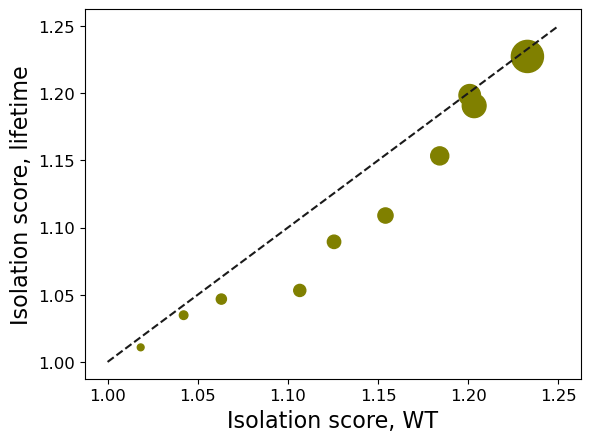

In [64]:
sns.reset_defaults()


plt.scatter( merged_df['isoscore_x'], merged_df['isoscore_y'], s=np.sqrt(merged_df['clife'])*5, color = 'olive')

plt.plot([1,1.25],[1,1.25],'--k')
plt.xlabel('Isolation score, WT',fontsize=16)
plt.ylabel('Isolation score, lifetime', fontsize =16)
#plt.legend(  bbox_to_anchor=(1,1))
#plt.ylim(0.9,1.35)
#plt.legend(fontsize=11.95)
plt.xticks(fontsize=11.95)
plt.yticks(fontsize=11.95)
plt.savefig('isowt_vs_isowapl.pdf',transparent=True, ppt=500)

#plt.grid(True)
plt.show()

In [42]:
clife_list = [22.86, 342.86, 571.43, 11428.57]

merged_df_sort = merged_df[merged_df['clife'].isin(clife_list)]
merged_df_sort = merged_df_sort.sort_values('clife')
merged_df_sort

,life_x,velocity,clife,cof,isoscore_x,occup,life_y,isoscore_y
3,500.0,1,22.86,9.80,1.018362,0.7,1500.0,1.010843
6,500.0,1,342.86,146.94,1.125558,0.7,1500.0,1.089363
9,500.0,1,571.43,244.90,1.154081,0.7,1500.0,1.108930
2,500.0,1,11428.57,4897.96,1.232775,0.7,1500.0,1.227295


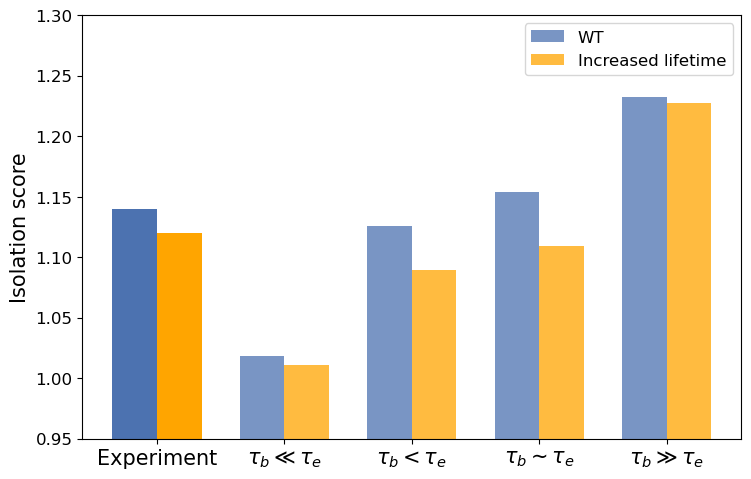

In [99]:
# Define tau_e for comparison
tau_e = 500
convertor = 21.875*60/500
# Add a new column for labels based on conditions
def get_label(clife, tau_e):
    if clife < 0.1 * tau_e:
        return r'$\tau_b \ll \tau_e$'
    elif 0.1 * tau_e < clife < tau_e:
        return r'$\tau_b < \tau_e$'
    elif clife > 1.5 * tau_e:
        return r'$\tau_b \gg \tau_e$'
    else:
        return r'$\tau_b \sim \tau_e$'

merged_df_sort['label'] = merged_df_sort['clife'].apply(lambda x: get_label(x, tau_e))

# Plotting
fig, ax = plt.subplots(figsize=(8.5, 5.5))

# Define the bar width
bar_width = 0.35

# Plot bars for experimental data at the beginning
exp_index = 0  # Positioning them at the beginning of the plot
exp_x = 1.14
exp_y = 1.12
bars3 = ax.bar(exp_index, exp_x, bar_width, color = 'b')#, label=r'WT, Liu et al, 2021', color='b')#WT, Liu et al, 2020
bars4 = ax.bar(exp_index + bar_width, exp_y, bar_width, color = 'orange')#, label=r'Wapl 6h, Liu et al, 2021', color='orange')

# Create positions for bars and plot for merged_df_sort
index = np.arange(1, len(merged_df_sort) + 1)  # Start from 1 for the subsequent data
bars1 = ax.bar(index, merged_df_sort['isoscore_x'], bar_width, label='WT', color='b', alpha = 0.75)
bars2 = ax.bar(index + bar_width, merged_df_sort['isoscore_y'], bar_width, label='Increased lifetime', color='orange', alpha = 0.75)

# Set labels and title
ax.set_ylabel('Isolation score', fontsize=15)

# Adjust x-ticks to align with the bars
ax.set_xticks(np.append(exp_index + bar_width / 2, index + bar_width / 2))
ax.set_xticklabels(['Experiment'] + list(merged_df_sort['label']), fontsize = 15)
#ax.set_yticklabels(fontsize = 15)
# Set y-axis limits
ax.set_ylim(0.95, 1.3)
ax.tick_params(axis='y', labelsize=12) 
# Add a legend
ax.legend(fontsize = 11.95)
plt.savefig('bar_for_isolation.pdf', transparent = True)
# Show plot
plt.show()


### Frip vs isolation analysis

In [16]:
lifes, vels = [500, 1500] , [1, 3]

iso=pd.read_csv('../../../data/isoscore_for_dynamic_random_pause_mod_1_5_30_traiangles_coolres10_s_points.csv')

frip = pd.read_csv('../../../python_codes_calculations/data/fripscore_hres_points.csv')
mat = []
for life in lifes:
    for vel in vels:
        if (life==1500 and vel==3): continue
        new_frip =frip[(frip['lifetime'] == life)&(frip[' velocity'] == vel)][[' clife',' cof', ' fripscore']]
        new_iso = iso[(iso['life'] == life)&(iso['velocity'] == vel)][['clife','cof', 'isoscore']]
        new_frip_filtered = new_frip.drop_duplicates(keep = 'first')
        new_iso_filtered = new_iso.drop_duplicates(keep = 'first')
        new_frip_filtered = new_frip_filtered.sort_values(' clife')
        new_iso_filtered = new_iso_filtered.sort_values('clife')
        new_clife = new_iso_filtered['clife']
        frip_score = new_frip_filtered[' fripscore']
        iso_score = new_iso_filtered['isoscore']
      
        mat.append([vel, life, np.mean(frip_score), np.mean(iso_score)])

mat = np.array(mat)
iso

,life,velocity,clife,cof,isoscore
0,1500.0,1,11.43,1.27,1.012846
1,2500.0,1,11.43,1.27,1.003143
2,500.0,1,11.43,1.27,1.026904
3,1500.0,1,11.43,11.43,1.003604
4,2500.0,1,11.43,11.43,1.014636
...,...,...,...,...,...
237,2500.0,1,571.43,857.14,1.065710
238,500.0,1,571.43,857.14,1.079523
239,1500.0,1,571.43,97.96,1.144802
240,2500.0,1,571.43,97.96,1.118863


In [17]:
frip = pd.read_csv('../../../python_codes_calculations/data/fripscore_hres_points.csv')


#frip =frip[(frip[' clife']!=500000)&(frip[' cof']>=0.3)]
frip = frip[frip['sep']==100]
lifetime =frip['lifetime']
velocity =frip[' velocity']
clife =frip[' clife']
cof =frip[' cof']
frip[' occup']=(1*(frip[' clife'])/(frip[' clife']+frip[' cof']))

unique_life = np.unique(lifetime)
unique_vel = np.unique(velocity)
unique_clife = np.unique(clife)
unique_cof = np.unique(cof)
unique_occupancy = np.unique(frip[' occup'])
#print(list(unique_occupancy))
frip

,lifetime,velocity,clife,cof,sep,fripscore,occup
0,1000.0,1,11.43,0.60,100,0.055805,0.950125
2,1500.0,1,11.43,0.60,100,0.052975,0.950125
4,500.0,1,11.43,0.60,100,0.049505,0.950125
6,1000.0,1,11.43,1.27,100,0.031351,0.900000
8,1500.0,1,11.43,1.27,100,0.035712,0.900000
...,...,...,...,...,...,...,...
1694,1500.0,1,5714.29,8571.43,100,0.349201,0.400000
1696,500.0,1,5714.29,8571.43,100,0.201629,0.400000
1698,1000.0,1,5714.29,979.59,100,0.493832,0.853659
1700,1500.0,1,5714.29,979.59,100,0.562083,0.853659


In [26]:
lifes, vels = [500, 1500] , [1, 3]

file= open('frip_iso_tau.csv','w')
file.write('vel,life,clife,frip_ave,iso_ave\n')
mat = []
for life in lifes:
    for vel in vels:
        if (life==1500 and vel==3): continue
        for clife in unique_clife:
            #print(clife)
            new_frip = frip[(frip['lifetime'] == life)&(frip[' velocity'] == vel)&(frip[' clife']==clife)][[' occup',' cof', ' fripscore']]
            new_iso = iso[(iso['life'] == life)&(iso['velocity'] == vel)&(iso['clife']==clife)][['occup','cof', 'isoscore']]
            new_frip_filtered = new_frip.drop_duplicates(keep = 'first')
            new_iso_filtered = new_iso.drop_duplicates(keep = 'first')
            new_frip_filtered = new_frip_filtered.sort_values(' occup')
            new_iso_filtered = new_iso_filtered.sort_values('occup')
            new_clife = new_iso_filtered['occup']
            frip_score = new_frip_filtered[' fripscore']
            iso_score = new_iso_filtered['isoscore']
            if frip_score.empty or iso_score.empty:
                #print('y')
                continue
            mat.append([vel, life, clife, np.mean(frip_score), np.mean(iso_score)])
            file.write('%s,%s,%s,%s,%s\n'%(vel, life, clife, np.mean(frip_score), np.mean(iso_score)))

mat = np.array(mat)
file.close()

In [27]:
file = pd.read_csv('../../data/frip_iso_occup.csv')
file = file[(file['occupancy_rate']<0.999)&(file['occupancy_rate']>0.4)]
file

,vel,life,occupancy_rate,frip_ave,iso_ave
11,1,500,0.500000,0.123237,1.177047
12,1,500,0.600000,0.120223,1.045802
13,1,500,0.666667,0.096314,1.073506
14,1,500,0.769231,0.167256,1.294320
15,1,500,0.909091,0.193509,1.080279
16,1,500,0.967742,0.258684,1.178429
17,1,500,0.970874,0.276853,1.135371
18,1,500,0.990099,0.327676,1.319678
19,1,500,0.993377,0.301783,1.247571
20,1,500,0.994036,0.313171,1.206069


### Frip vs iso for various tau_b

In [7]:
frip = pd.read_csv('../../../python_codes_calculations/data/fripscore_hres_points.csv')


#frip = frip[(frip[' clife']<=5000)&(frip[' cof']>=0.3)]
frip = frip[frip['sep']==100]
lifetime = frip['lifetime']
velocity = frip[' velocity']
clife = frip[' clife']
cof = frip[' cof']
frip['occup']=(1*(frip[' clife'])/(frip[' clife']+frip[' cof']))
frip['occup']=frip['occup'].round(2)
unique_life = np.unique(lifetime)
unique_vel = np.unique(velocity)
unique_clife = np.unique(clife)
unique_cof = np.unique(cof)
unique_occupancy = np.unique(frip['occup'])

#frip=frip[frip[' clife']==10*frip[' cof']]
#frip=frip[frip['occup']==0.9]
frip


,lifetime,velocity,clife,cof,sep,fripscore,occup
0,1000.0,1,11.43,0.60,100,0.055805,0.95
2,1500.0,1,11.43,0.60,100,0.052975,0.95
4,500.0,1,11.43,0.60,100,0.049505,0.95
6,1000.0,1,11.43,1.27,100,0.031351,0.90
8,1500.0,1,11.43,1.27,100,0.035712,0.90
...,...,...,...,...,...,...,...
1694,1500.0,1,5714.29,8571.43,100,0.349201,0.40
1696,500.0,1,5714.29,8571.43,100,0.201629,0.40
1698,1000.0,1,5714.29,979.59,100,0.493832,0.85
1700,1500.0,1,5714.29,979.59,100,0.562083,0.85


In [9]:
iso=pd.read_csv('../../../data/isoscore_for_dynamic_random_pause_mod_1_5_30_traiangles_coolres10_s_points.csv')

lifetime = iso['life']
velocity = iso['velocity']
clifetime = iso['clife']
coftime = iso['cof']
isoscore = iso['isoscore']
iso['occup']=(1*(iso['clife'])/(iso['clife']+iso['cof']))
iso['occup']=iso['occup'].round(2)
unique_life = np.unique(lifetime)
unique_vel = np.unique(velocity)
unique_clife = np.unique(clifetime)
unique_cof = np.unique(coftime)
unique_occupancy = np.unique(iso['occup'])


#iso=iso[iso['clife']==10*iso['cof']]
#iso = iso[iso['occup']==0.9]
iso

,life,velocity,clife,cof,isoscore,occup
0,1500.0,1,11.43,1.27,1.012846,0.90
1,2500.0,1,11.43,1.27,1.003143,0.90
2,500.0,1,11.43,1.27,1.026904,0.90
3,1500.0,1,11.43,11.43,1.003604,0.50
4,2500.0,1,11.43,11.43,1.014636,0.50
...,...,...,...,...,...,...
237,2500.0,1,571.43,857.14,1.065710,0.40
238,500.0,1,571.43,857.14,1.079523,0.40
239,1500.0,1,571.43,97.96,1.144802,0.85
240,2500.0,1,571.43,97.96,1.118863,0.85


In [10]:
print(unique_clife)

[   11.43    22.86    57.14   114.29   228.57   342.86   571.43  1142.86
  2285.71  3428.57 11428.57]


In [24]:
lifes, vels = [500, 1500] , [1, 3]

file= open('frip_iso_tau_points.csv','w')
file.write('vel,life,clife,occup,frip_ave,iso_ave\n')
mat = []
for life in lifes:
    for vel in vels:
        if (life==1500 and vel==3): continue
        for clife in unique_clife:
            #print(clife)
            new_frip = frip[(frip['lifetime'] == life)&(frip[' velocity'] == vel)&(frip[' clife']==clife)][['occup',' cof', ' fripscore']]
            new_iso = iso[(iso['life'] == life)&(iso['velocity'] == vel)&(iso['clife']==clife)][['occup','cof', 'isoscore']]
            new_frip_filtered = new_frip.drop_duplicates(keep = 'first')
            new_iso_filtered = new_iso.drop_duplicates(keep = 'first')
            new_frip_filtered = new_frip_filtered.sort_values('occup')
            new_iso_filtered = new_iso_filtered.sort_values('occup')
            new_clife = new_iso_filtered['occup']
            frip_score = new_frip_filtered[' fripscore']
            iso_score = new_iso_filtered['isoscore']
            if frip_score.empty or iso_score.empty:
                #print('y')
                continue
            mat.append([vel, life, clife, np.mean(frip_score), np.mean(iso_score)])
            file.write('%s,%s,%s,%s,%s,%s\n'%(vel, life, clife, np.mean(frip_score), np.mean(iso_score)))

mat = np.array(mat)
file.close()

In [14]:
frip_df

,lifetime,velocity,clife,cof,sep,fripscore,life
0,1000.0,1,11.43,0.60,100,0.055805,1000.0
2,1500.0,1,11.43,0.60,100,0.052975,1500.0
4,500.0,1,11.43,0.60,100,0.049505,500.0
6,1000.0,1,11.43,1.27,100,0.031351,1000.0
8,1500.0,1,11.43,1.27,100,0.035712,1500.0
...,...,...,...,...,...,...,...
1694,1500.0,1,5714.29,8571.43,100,0.349201,1500.0
1696,500.0,1,5714.29,8571.43,100,0.201629,500.0
1698,1000.0,1,5714.29,979.59,100,0.493832,1000.0
1700,1500.0,1,5714.29,979.59,100,0.562083,1500.0


In [24]:
# Load the datasets

frip_df = pd.read_csv('../../../python_codes_calculations/data/fripscore_hres_points.csv')
frip_df = frip_df[frip_df['sep']==100]
frip_df['life']=frip_df['lifetime']
frip_df['velocity']=frip_df[' velocity']
frip_df['clife']=frip_df[' clife']
frip_df['cof']=frip_df[' cof']
frip_df = frip_df[['life','velocity','clife','cof',' fripscore']]
iso_df = pd.read_csv('../../../data/isoscore_for_dynamic_random_pause_mod_1_5_30_traiangles_coolres10_s_points.csv')

# Define the common columns
common_columns = ['life', 'velocity', 'clife', 'cof']

# Merge the datasets on the common columns
merged_df = pd.merge(frip_df, iso_df, on=common_columns, how='inner')

#merged_df['occup']==(merged_df['clife']/(merged_df['clife']+merged_df['cof'])).round(2)

# Optionally, save the merged dataset to a new CSV file
merged_df.to_csv('merged_frip_iso.csv', index=False)
merged_df

,life,velocity,clife,cof,fripscore,isoscore
0,1500.0,1,11.43,1.27,0.035712,1.012846
1,500.0,1,11.43,1.27,0.037794,1.026904
2,1500.0,1,11.43,11.43,0.020537,1.003604
3,500.0,1,11.43,11.43,0.018845,1.004709
4,1500.0,1,11.43,2.86,0.029089,1.019694
...,...,...,...,...,...,...
160,500.0,1,571.43,63.49,0.278267,1.205129
161,1500.0,1,571.43,857.14,0.187597,1.054362
162,500.0,1,571.43,857.14,0.136925,1.079523
163,1500.0,1,571.43,97.96,0.333422,1.144802


In [25]:
file = 'frip_iso_tau_points.csv'  
data = pd.read_csv(file)
data

,vel,life,clife,frip_ave,iso_ave
0,1,500,11.43,0.037817,1.026904
1,1,500,22.86,0.053213,1.038615
2,1,500,57.14,0.087573,1.061107
3,1,500,114.29,0.135630,1.100663
4,1,500,228.57,0.195006,1.146637
5,1,500,342.86,0.230220,1.163837
6,1,500,571.43,0.282968,1.194242
7,1,500,1142.86,0.333492,1.247462
8,1,500,2285.71,0.369961,1.292935
9,1,500,3428.57,0.386022,1.301032


In [27]:
file = 'merged_frip_iso.csv'  
data = pd.read_csv(file)
data['occup']=(data['clife']/(data['clife']+data['cof'])).round(2)
data_70 = data[data['occup']==0.70]
data_70

,life,velocity,clife,cof,fripscore,isoscore,occup
6,1500.0,1,11.43,4.90,0.027831,0.996969,0.7
17,1500.0,1,114.29,48.98,0.111592,1.047369,0.7
18,500.0,1,114.29,48.98,0.099076,1.060682,0.7
33,1500.0,1,1142.86,489.80,0.368312,1.154109,0.7
34,500.0,1,1142.86,489.80,0.272606,1.187553,0.7
47,1500.0,1,11428.57,4897.96,0.530745,1.243910,0.7
48,500.0,1,11428.57,4897.96,0.342387,1.234193,0.7
63,1500.0,1,22.86,9.80,0.037145,1.005287,0.7
64,500.0,1,22.86,9.80,0.036218,1.019844,0.7
81,1500.0,1,228.57,97.96,0.179924,1.063189,0.7


In [38]:
unique_life

array([1500.,  500.])

In [41]:
np.unique(data_70['clife'])

array([   11.43,    22.86,    57.14,   114.29,   228.57,   342.86,
         571.43,  1142.86,  2285.71,  3428.57, 11428.57])

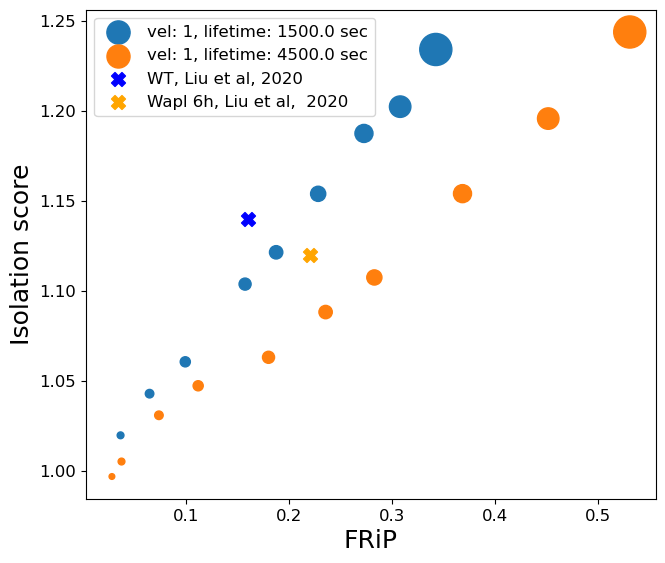

In [44]:
file = 'merged_frip_iso.csv'  
data = pd.read_csv(file)
data['occup']=(data['clife']/(data['clife']+data['cof'])).round(2)
data=data[data['clife']>5]
unique_vel = data['velocity'].unique()
unique_life = np.sort(data['life'].unique())

data_70 = data[data['occup']==0.70]
sns.reset_defaults()
plt.figure(figsize=(7.35, 6.35))
clife_range=[   11.43,    22.86,    57.14,   114.29,   228.57,   342.86,
         571.43,  1142.86,  2285.71, 11428.57]
data_70 = data_70[data_70['clife'].isin(clife_range)]

for i, vel in enumerate(unique_vel):
    for j, life in enumerate(unique_life):
        if vel==3.0 and life==1500.0: continue
        if vel==3.0: continue
        subset = data_70[(data_70['velocity'] == vel) & (data_70['life'] == life)]
        #print(subset)
        plt.scatter(subset[' fripscore'],subset['isoscore'],  
                    s=np.sqrt(subset['clife'])*5, label=f'vel: {vel}, lifetime: {life*3} sec')
Liu_WT = [0.16, 1.14]
Liu_Wapl = [0.22, 1.12]
plt.scatter(np.array(Liu_WT)[0], np.array(Liu_WT)[1], label='WT, Liu et al, 2020',color='blue', marker='X', s=100)
plt.scatter(np.array(Liu_Wapl)[0], np.array(Liu_Wapl)[1],label='Wapl 6h, Liu et al,  2020',color='orange', marker = 'X', s=100)
plt.xlabel('FRiP',fontsize=18)
plt.ylabel('Isolation score', fontsize =18)
#plt.title('Frip vs peak')
#plt.legend(  bbox_to_anchor=(1,1))
#plt.ylim(0.9,1.35)
plt.legend(fontsize=11.95)
plt.xticks(fontsize=11.95)
plt.yticks(fontsize=11.95)
#plt.savefig('../../images/iso_vs_frip.pdf',transparent=True, ppt=500)

#plt.grid(True)
plt.show()

In [ ]:
file = 'frip_iso_tau.csv'  
data = pd.read_csv(file)
#data = data[(data['occupancy_rate']<0.999)&(data['occupancy_rate']>0.78)]
data=data[data['clife']>5]
unique_vel = data['vel'].unique()
unique_life = data['life'].unique()

#colors = plt.cm.viridis(np.linspace(0, 1, len(unique_vel) * len(unique_life)))
sns.reset_defaults()
plt.figure(figsize=(7.35, 6.35))
for i, vel in enumerate(unique_vel):
    for j, life in enumerate(unique_life):
        if vel==3.0 and life==1500.0: continue
        if vel==3.0: continue
        subset = data[(data['vel'] == vel) & (data['life'] == life)]
        plt.scatter(subset['frip_ave'],subset['iso_ave'],  
                    s=np.sqrt(subset['clife'])*4.5, label=f'vel: {vel}, lifetime: {life*3} sec')
Liu_WT = [0.16, 1.14]
Liu_Wapl = [0.22, 1.12]
plt.scatter(np.array(Liu_WT)[0], np.array(Liu_WT)[1], label='WT, Liu et al, 2020',color='blue', marker='X', s=100)
plt.scatter(np.array(Liu_Wapl)[0], np.array(Liu_Wapl)[1],label='Wapl 6h, Liu et al,  2020',color='orange', marker = 'X', s=100)
plt.xlabel('FRiP',fontsize=18)
plt.ylabel('Isolation score', fontsize =18)
#plt.title('Frip vs peak')
#plt.legend(  bbox_to_anchor=(1,1))
#plt.ylim(0.9,1.35)
plt.legend(fontsize=11.95)
plt.xticks(fontsize=11.95)
plt.yticks(fontsize=11.95)
#plt.savefig('../../images/iso_vs_frip.pdf',transparent=True, ppt=500)

#plt.grid(True)
plt.show()

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ppt" which is no longer supported as of 3.3 and will become an error in 3.6


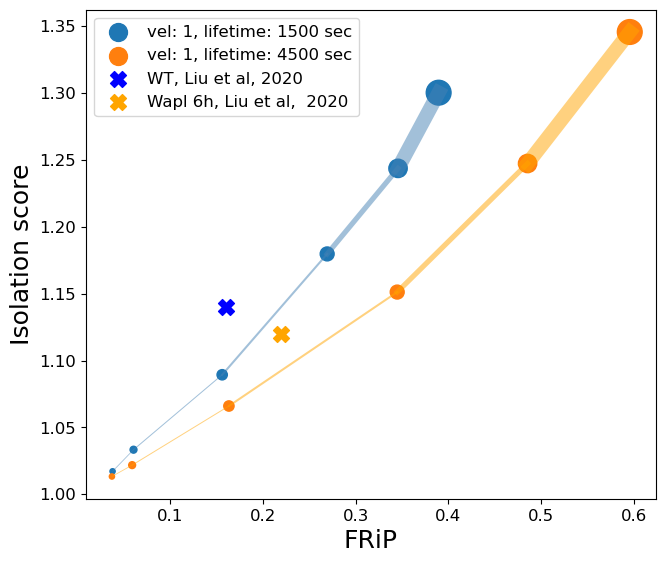

In [27]:
file = 'frip_iso_tau.csv'
data = pd.read_csv(file)
data = data[data['clife'] > 5]
unique_vel = data['vel'].unique()
unique_life = data['life'].unique()

sns.reset_defaults()
plt.figure(figsize=(7.35, 6.35))

for i, vel in enumerate(unique_vel):
    for j, life in enumerate(unique_life):
        if vel == 3.0 and life == 1500.0: continue
        if vel == 3.0: continue
        subset = data[(data['vel'] == vel) & (data['life'] == life)]
        plt.scatter(subset['frip_ave'], subset['iso_ave'], 
                    s=np.sqrt(subset['clife']) * 4.5, label=f'vel: {vel}, lifetime: {life * 3} sec')
        if life==500: color='steelblue'
        if life==1500: color='orange'
        for k in range(len(subset) - 1):
            x_values = subset['frip_ave'].iloc[k:k+2]
            y_values = subset['iso_ave'].iloc[k:k+2]
            linewidth = 0.515+0.0065 * subset['clife'].iloc[k]
            plt.plot(x_values, y_values, linewidth=linewidth, alpha=0.5,color=color)

Liu_WT = [0.16, 1.14]
Liu_Wapl = [0.22, 1.12]
plt.scatter(np.array(Liu_WT)[0], np.array(Liu_WT)[1], label='WT, Liu et al, 2020', color='blue', marker='X', s=130)
plt.scatter(np.array(Liu_Wapl)[0], np.array(Liu_Wapl)[1], label='Wapl 6h, Liu et al,  2020', color='orange', marker='X', s=130)
plt.xlabel('FRiP', fontsize=18)
plt.ylabel('Isolation score', fontsize=18)
plt.legend(fontsize=11.95)
plt.xticks(fontsize=11.95)
plt.yticks(fontsize=11.95)
plt.savefig('../../../images/iso_vs_frip.pdf', transparent=True, ppt=500)

plt.show()
